In [3]:
import numpy as np
from skimage import io
import matplotlib
import matplotlib.pyplot as plt
import os
from glob import glob
import torch
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable

In [4]:

# If USE_CUDA is True, computations will be done using the GPU (may not work in all systems)
# This will make the calculations happen faster
USE_CUDA = torch.cuda.is_available()

DATASET_PATH = '/Users/hewanshrestha/Documents/HLCV/project/Why-Self-Supervision-in-Time/data/EuroSAT/'

BATCH_SIZE = 64 # Number of images that are used for calculating gradients at each step

NUM_EPOCHS = 25 # Number of times we will go through all the training images. Do not go over 25

LEARNING_RATE = 0.001 # Controls the step size
MOMENTUM = 0.9 # Momentum for the gradient descent
WEIGHT_DECAY = 0.0005

In [5]:
# Create datasets and data loaders
# Transformations

from torchvision import datasets, models, transforms
data_transforms = transforms.Compose([
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

train_dataset = datasets.ImageFolder(os.path.join(DATASET_PATH, 'train'), data_transforms)
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)



test_dataset = datasets.ImageFolder(os.path.join(DATASET_PATH, 'test'), data_transforms)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

class_names = train_dataset.classes

print('Dataloaders OK')
test_loader

Dataloaders OK


/Users/hewanshrestha/Documents/HLCV/project/Why-Self-Supervision-in-Time/.hlcv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Image label: 6


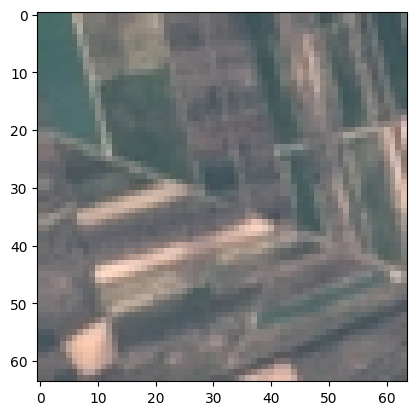

In [6]:
#Print the corresponding label for the image

random_image = train_dataset[13421][0].numpy().transpose((1, 2, 0))   
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
random_image = std * random_image + mean
random_image = np.clip(random_image, 0, 1)
print("Image label:", train_dataset[13421][1])
plt.imshow(random_image)

In [7]:
#Create the model class with ResNet
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [8]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16 
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16) 
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0], 1)
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(16)
        self.fc = nn.Linear(64, num_classes)
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(conv3x3(self.in_channels, out_channels, stride=stride),
                                       nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(x.size(0), -1)
        out = self.fc(out)
        return out

In [9]:
# Create network
model = ResNet(ResidualBlock, [2, 2, 2])
if USE_CUDA:
    model = model.cuda()  

In [11]:
# Define criterion, optimizer, and scheduler

criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [12]:
# Main loop
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
epochs = []

for epoch in range(1, NUM_EPOCHS+1):
    print(f'Epoch {epoch} of {NUM_EPOCHS}')
    epochs.append(epoch)

    #-------------------------Train-------------------------
    
    #Reset these below variables to 0 at the begining of every epoch
    correct = 0
    iterations = 0
    iter_loss = 0.0
    
    model.train()  # Put the network into training mode
    
    for i, (inputs, labels) in enumerate(train_loader):
        if USE_CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()        
            
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        iter_loss += loss.item()  # Accumulate the loss
        optimizer.zero_grad() # Clear off the gradient in (w = w - gradient)
        loss.backward()   # Backpropagation 
        optimizer.step()  # Update the weights
        
        # Record the correct predictions for training data 
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        iterations += 1
        
    scheduler.step()
        
    # Record the training loss
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct / len(train_dataset)))   
     
    #-------------------------Test--------------------------
    
    correct = 0
    iterations = 0
    testing_loss = 0.0
    
    model.eval()  # Put the network into evaluation mode
    
    for i, (inputs, labels) in enumerate(test_loader):

        if USE_CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        outputs = model(inputs)     
        loss = criterion(outputs, labels) # Calculate the loss
        testing_loss += loss.item()
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        
        iterations += 1

    # Record the Testing loss
    test_loss.append(testing_loss/iterations)
    # Record the Testing accuracy
    test_accuracy.append((100 * correct / len(test_dataset)))
   
    print(f'Epoch {epoch} Train results: Loss={train_loss[-1]} | Accuracy={train_accuracy[-1]}')
    print(f'Epoch {epoch} Test results: Loss={test_loss[-1]} | Accuracy={test_accuracy[-1]}\n')


Epoch 1 of 25


/Users/hewanshrestha/Documents/HLCV/project/Why-Self-Supervision-in-Time/.hlcv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/hewanshrestha/Documents/HLCV/project/Why-Self-Supervision-in-Time/.hlcv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/hewanshrestha/Documents/HLCV/project/Why-Self-Supervision-in-Time/.hlcv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/hewanshrestha/Documen

Epoch 1 Train results: Loss=1.205355741568571 | Accuracy=58.80555725097656
Epoch 1 Test results: Loss=1.101340347944304 | Accuracy=62.85185241699219

Epoch 2 of 25


/Users/hewanshrestha/Documents/HLCV/project/Why-Self-Supervision-in-Time/.hlcv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/hewanshrestha/Documents/HLCV/project/Why-Self-Supervision-in-Time/.hlcv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# Plot and save
plt.figure(figsize=(12, 8), num=1)
plt.clf()
plt.plot(epochs, train_loss, label='Train')
plt.plot(epochs, test_loss, label='Test')
plt.legend()
plt.grid()
plt.title('Cross entropy loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
    # plt.savefig('outputs/01-loss-resnet.pdf')

plt.figure(figsize=(12, 8), num=2)
plt.clf()
plt.plot(epochs, train_accuracy, label='Train')
plt.plot(epochs, test_accuracy, label='Test')
plt.legend()
plt.grid()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
    # plt.savefig('outputs/02-accuracy-resnet.pdf')

In [ ]:
print(f'Final train loss: {train_loss[-1]}')
print(f'Final test loss: {test_loss[-1]}')
print(f'Final train accuracy: {train_accuracy[-1]}')
print(f'Final test accuracy: {test_accuracy[-1]}')

In [ ]:
model = ResNet(ResidualBlock, [2, 2, 2])
model.eval()

In [ ]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [ ]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_dataset), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

In [ ]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model, 
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

In [ ]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

In [ ]:
test_labels, pred_classes


In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Set the figure size and number of rows and columns
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3

for i, sample in enumerate(test_samples):
    # Create a subplot
    plt.subplot(nrows, ncols, i+1)

    # Convert the sample to a numpy array and transpose it if necessary
    image_data = sample.squeeze().cpu().numpy()

    # Ensure the image data has the correct shape
    if len(image_data.shape) == 3:
        image_data = image_data.transpose(1, 2, 0)

    # Normalize the pixel values to the range [0, 1]
    image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))

    # Plot the target image
    plt.imshow(image_data)

    # Find the prediction label (in text form, e.g. "Sandal")
    pred_label = class_names[pred_classes[i]]

    # Get the truth label (in text form, e.g. "T-shirt")
    truth_label = class_names[test_labels[i]] 

    # Create the title text of the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality and change title color accordingly
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, color="g")  # Green text if correct
    else:
        plt.title(title_text, fontsize=10, color="r")  # Red text if wrong

    plt.axis(False)

plt.show()
